In [133]:
import numpy as np
from scipy.integrate import *
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

In [173]:
class ForwardPhi(nn.Module):
    def __init__(self, input_size, output_size, kernel_size):
        super().__init__()
        self.network = nn.Sequential(nn.Conv1d(input_size, 2, kernel_size),
                                      nn.ReLU(),
                                     nn.Conv1d(2, 1, kernel_size),
                                      nn.LazyLinear(output_size)
        )
    
    def forward(self, X):
        return self.network(X)
    
    def validate(self, X_val, y_val):
        losses = []
        for i in range(len(X_val)):
            x, y = X_val[i], y_val[i]
            prediction = self.forward(x.T)
            loss = nn.MSELoss()
            output = loss(y, prediction)
            losses.append(output.detach().numpy())
        return np.array(losses)
        
    
    def train_network(self, X_train, y_train):
        losses = []
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        for i in range(len(X_train)):
            x, y = X_train[i], y_train[i]
            prediction = self.forward(x.T)
            loss = nn.MSELoss()
            output = loss(y, prediction)

            optimizer.zero_grad()
            output.backward()
            optimizer.step()
            losses.append(output.detach().numpy())
        return np.array(losses)
            
            
    

In [3]:
def sir_odes(initial_values, infection_rate, recovery_rate, population):
    s_t, i_t, _ = initial_values
    
    dS = -infection_rate * (s_t * i_t)/population
    dR = recovery_rate * i_t
    dI = -dS - dR
    
    return np.array([dS, dI, dR])

    

In [4]:
def forward_euler(f, iv, delta_t, number_of_steps):
    solution = [np.array(iv)]
    time = np.array([delta_t * i for i in range(number_of_steps)])
    for i in range(len(time)):
        t = time[i]
        solution.append(solution[i] + delta_t * f(solution[i]))
    
    return np.array(solution)
    
    
    

In [5]:
def generate_deltas(results, L = 0, rho=1, sigma_2=0):
    assert L >= 0
    assert rho <= 1
    s = results[:, 0]
    r = results[:, 2]
    deltas =np.array([(s[(t-L)-1] - s[(t-L)], r[(t-L)] - r[(t-L) - 1]) for t in range(L + 1, len(s))])
    noise = np.random.normal(rho, sigma_2, deltas.shape)
    deltas *= noise
    return deltas

In [6]:
def simulate_sir_simple(lam, mu, I_0, T):
    assert I_0 >= 0 and I_0 <= 1
    ivs = [1 - I_0, I_0, 0]
    odes = lambda ivs: sir_odes(ivs, lam, mu, 1)
    
    return forward_euler(odes, ivs, 1, T)
    

In [7]:
def simulate_sir_noisy(lam, mu, I_0, L, rho, sigma_2, T):
    results, _ = simulate(am, mu, I_0, T)
    

In [8]:
def plot_simulation(lam, mu, I_0, T):
    results = simulate_sir_simple(lam, mu, I_0, T)
    deltas = generate_deltas(results)
    s = results[:, 0]
    i = results[:, 1]
    r = results[:, 2]
    time_range = [t for t in range(T + 1)]
    plt.scatter(time_range, s, label="Susceptible", marker=".", s = 3, color="y")
    plt.scatter(time_range, i, label="Infected", marker="x", s = 3, color="r")
    plt.scatter(time_range, r, label="Recovered", marker=",", s= 3, color="g")
    plt.scatter(time_range, s + i + r, label="population", marker ="_", s = 3, color="k")
    plt.title(f"Simulation with parameters $\lambda$: {lam}, $\mu$: {mu}, $I_0$: {I_0}", usetex = True)
    plt.ylabel("Normalized population")
    plt.xlabel("Time")
    plt.legend()
    plt.figure()
    plt.title(f"Deltas of compartments S and R with parameters $\lambda$: {lam}, $\mu$: {mu}, $I_0$: {I_0}", usetex = True)
    plt.scatter(time_range[:-1], deltas[:, 0], marker="v", s=3, color="y", label="deltaS")
    plt.scatter(time_range[:-1], deltas[:, 1], marker="^", s=3, color="g", label="deltaR")
    plt.ylabel("Change in population")
    plt.xlabel("Time")
    plt.legend()

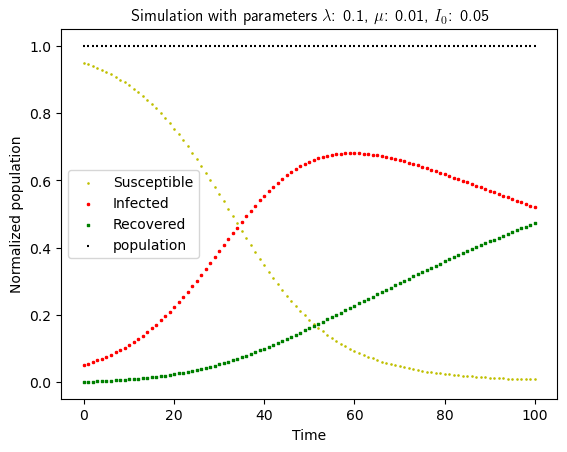

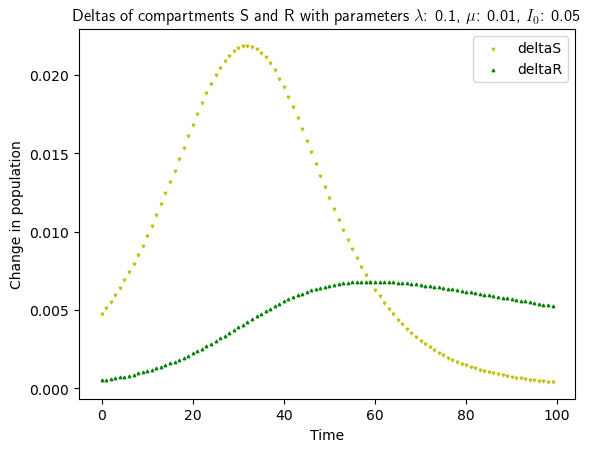

In [186]:
plot_simulation(0.1, 0.01, 0.05, 100)

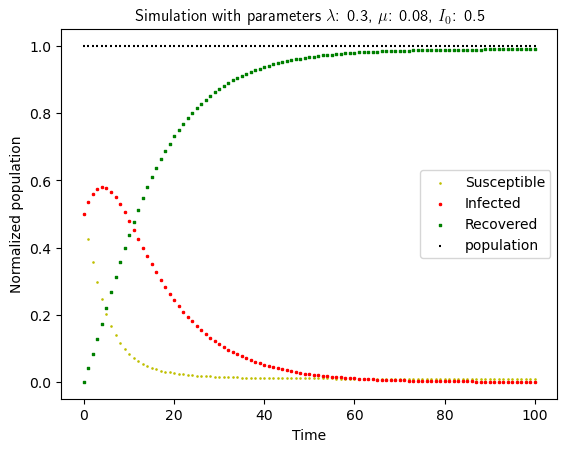

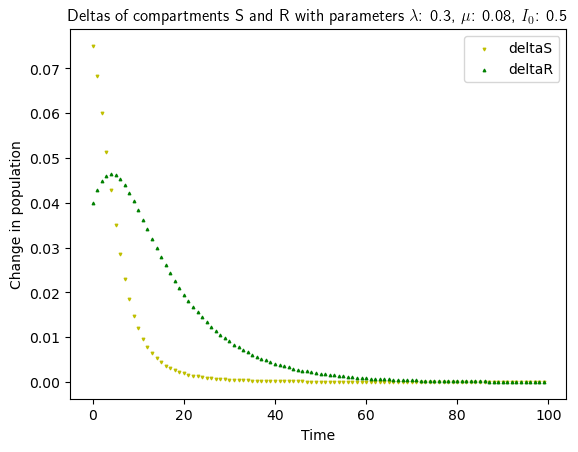

In [12]:
plot_simulation(0.3, 0.08, 0.5, 100)

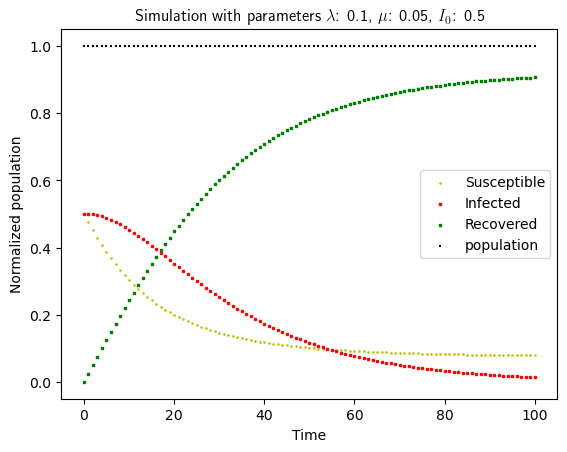

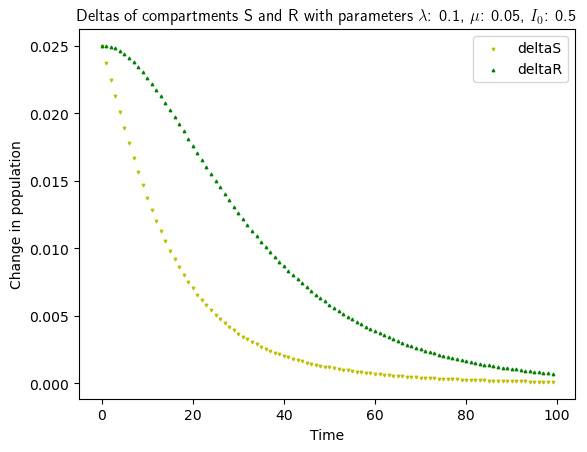

In [11]:
plot_simulation(0.1, 0.05, 0.5, 100)

Range of parameters: $\lambda \in [0.05, 0.3]$, $\mu \in [0.001, 0.08]$, $max I_0 \in [0.05, 0.5]$

Distributions: $p^{sim}(Y) = p^{sim}(\lambda) \cdotp p^{sim}(\mu) \cdotp p^{sim}(I_0) = U(0.05, 0.3) \cdotp U(0.001, 0.08) \cdotp U(0.05, 0.5)$

In [187]:
P = ForwardPhi(2, 3, 3)
data_set = []
Y = []
for i in range(1000):
    y = [np.random.uniform(0.1, 1), np.random.uniform(0.001, 0.08), np.random.uniform(0.005, 0.5)]
    sample = simulate_sir_simple(y[0], y[1], y[2], 100)
    deltas = np.array(generate_deltas(sample), dtype=np.float32)
    data_set.append(torch.tensor(deltas))
    Y.append(torch.tensor(y))
x_train = data_set[:100]
y_train = Y[:100]
x_test = data_set[100:]
y_test = Y[100:]

In [188]:
losses = P.train_network(x_train, y_train)

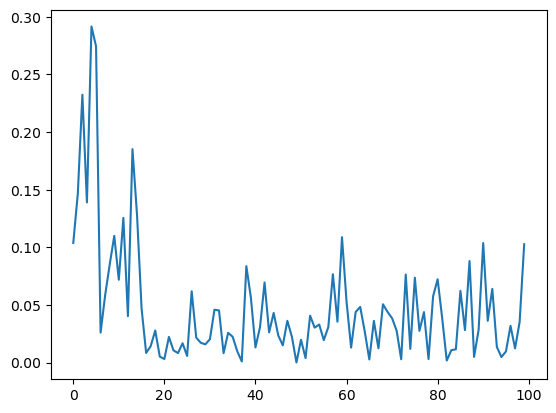

In [189]:
plt.plot(losses)

In [190]:
vals = P.validate(x_test, y_test)

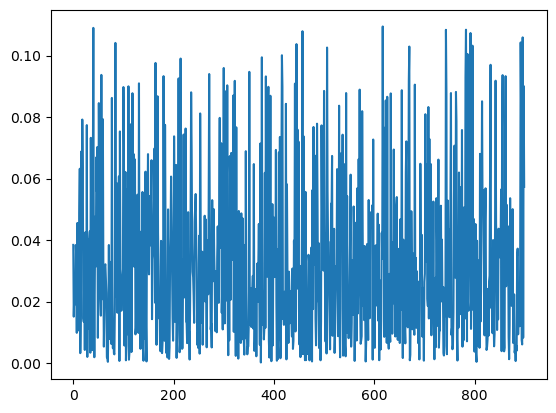

In [191]:
plt.plot(vals)